<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="250" align="center">

**PROCESAMIENTO DE LENGUAJE NATURAL**

*DESAFÍO Nº5 - SENTIMENT ANALYSIS CON EMBEDDINGS + LSTM - JUAN I. MUNAR*

**OBJETIVO.** El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from tensorflow.keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout
from keras.models import load_model
from keras.utils import plot_model

**DATOS.** Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas. Referencia del dataset: [LINK](https://www.kaggle.com/nicapotato/womens-ecommerce-clothing-reviews/version/1)

In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

Downloading...
From: https://drive.google.com/uc?id=1Urn1UFSrodN5BuW6-sc_igtaySGRwhV8
To: /content/clothing_ecommerce_reviews.csv
100%|██████████| 8.48M/8.48M [00:00<00:00, 45.6MB/s]


In [ ]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


**1. LIMPIEZA DE DATOS**



In [ ]:
# Creación de un nuevo dataset con las columnas elegidas y eliminando nulos
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()

# Transformación del rating de 0 a 4
df_reviews['Rating'] = df_reviews['Rating'] - 1

# Visualización
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


In [ ]:
# Distribución de valores respecto a columna rating
df_reviews['Rating'].value_counts()

4    12540
3     4908
2     2823
1     1549
0      821
Name: Rating, dtype: int64

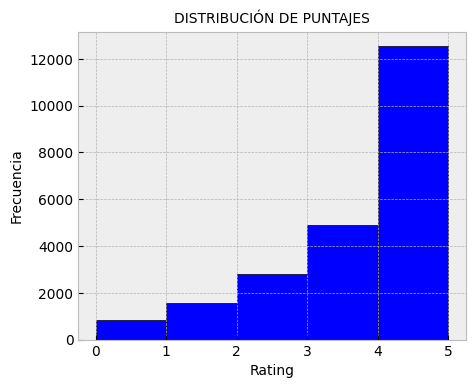

In [ ]:
# Plot
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.hist(df_reviews['Rating'],
         bins = [i for i in range(6)],
         edgecolor = 'black',
         color = 'blue')
plt.title('DISTRIBUCIÓN DE PUNTAJES', fontsize=10)
plt.xlabel('Rating')
plt.ylabel('Frecuencia')
plt.show()

In [ ]:
# Descripción estadística
df_reviews.describe()

,Rating
count,22641.000000
mean,3.183561
std,1.115762
min,0.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,4.000000


In [ ]:
# Vector de reviews
text_sequences = df_reviews['Review Text'].values
type(text_sequences)

numpy.ndarray

In [ ]:
# El vector de reviews tiene las siguientes dimensiones
text_sequences.shape

(22641,)

In [ ]:
# Creación del corpus
corpus = ' '.join(text_sequences)

In [ ]:
# El corpus tiene la siguiente cantidad de palabras:
len(corpus)

7011643

In [ ]:
# Se separan las palabras en tokens
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [ ]:
# Primeros tokens
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [ ]:
# La cantidad de tokens es:
len(tokens)

1372203

In [ ]:
# Importar el tokenizador de Keras
from keras.preprocessing.text import Tokenizer

# La cantidad máxima de palabras más frecuentes a guardar
num_words = 2000

# Se asigna a vocab_size
vocab_size = num_words

# Tokenizar
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(tokens)

In [ ]:
# Diccionario de palabra a índice
word_index = tok.word_index
print(f'tamaño de vocabulario : {len(word_index)}')

# Diccionario de índice a palabra
index_word = tok.index_word

tamaño de vocabulario : 14847


In [ ]:
# Conversión de palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [ ]:
# La oración más larga es:
seqs_lenght = [len(s) for s in sequences]
print(f'El máximo es {max(seqs_lenght)}')

El máximo es 115


In [ ]:
# Padding de las sentencias al mismo tamaño.
from tensorflow.keras.utils import pad_sequences
porcentaje_seq_max = 1
maxlen = int(max(seqs_lenght) * porcentaje_seq_max)
print(f'El largo máximo es {maxlen}')
print(f'Se procesan completamente el {round((np.array(seqs_lenght)<maxlen).mean()*100,1)}% de las oraciones')

# Obtención de variable X.
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

El largo máximo es 115
Se procesan completamente el 100.0% de las oraciones


In [ ]:
# Las dimensiones de la variable input son:
X.shape

(22641, 115)

In [ ]:
# Creación y transformación de la variable y a OHE.
y = to_categorical(df_reviews['Rating'].values, num_classes=5)
y.shape

(22641, 5)

In [ ]:
# División de datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Se determinan las dimensiones de entrada y salida.
in_shape = X_train.shape[1] # max input sentence len
out_shape = y.shape[1]
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 5


**2. ENTRENAR MODELOS**

El dataset se encuentra desbalanceado, más del 50% de las calificaciones corresponden a 5 estrellas. El uso de estos datos con accuracy como métrica puede llevar a resultados erróneos. Se probará con dos estrategias: sobremuestreo y F1 score.

*2.1. SMOTE + Embeddings + LSTM*

Se aplica el método *Synthetic Minority Oversampling Techinque* (SMOTE), se entrenan los embeddings.

In [ ]:
# Se importa SMOTE de la librería imblearn
from imblearn.over_sampling import SMOTE

# Se modifica la muestra
x_sm, y_sm  = SMOTE().fit_resample(X_train, y_train)

In [ ]:
# Desarmando el OHE
y_sm_inv = np.array([sum(y_sm[i] * np.array([0, 1, 2, 3, 4])) for
                     i in range(len(y_sm))])

# Se observa la nueva distribución
print(np.bincount(y_sm_inv))

# Limpieza
del(y_sm_inv)

[9995 9995 9995 9995 9995]


In [ ]:
# Desarrollando el f1 score
import keras.backend as K

def f1_score(y_true, y_pred):
    y_pred = K.round(y_pred)
    true_positives = K.sum(K.round(y_true * y_pred), axis=0)
    possible_positives = K.sum(K.round(y_true), axis=0)
    predicted_positives = K.sum(K.round(y_pred), axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return K.mean(f1)

In [ ]:
# Modelo con LSTM entrenando propios embeddings
model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = sentencias con padding a maxlen
# output_dim = L^0.25 --> crear embeddings de tamaño 10
model.add(Embedding(input_dim=vocab_size+1, output_dim=10, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=[f1_score, 'accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 115, 10)           20010     
                                                                 
 lstm (LSTM)                 (None, 115, 64)           19200     
                                                                 
 dropout (Dropout)           (None, 115, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 6

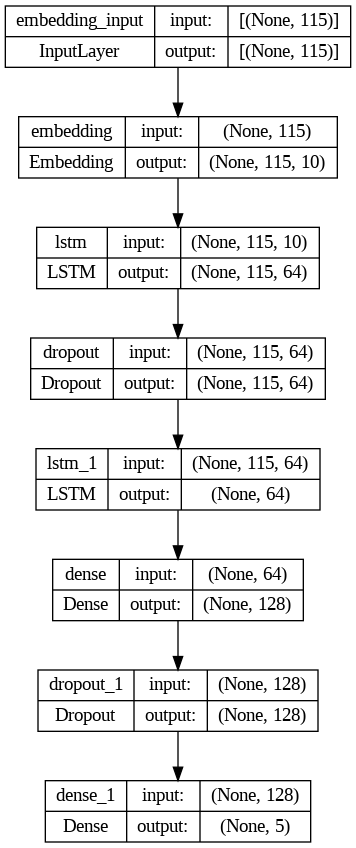

In [ ]:
# Plot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Punto para cargar el modelo para entrenar por partes
# model = load_model('smote_lstm_emb.keras')

In [ ]:
# Entreno el modelo
hist = model.fit(x_sm, y_sm, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
1562/1562 [==============================] - 58s 31ms/step - loss: 0.4680 - f1_score: 0.0886 - accuracy: 0.3077 - val_loss: 0.3970 - val_f1_score: 0.1362 - val_accuracy: 0.5478
Epoch 2/25
1562/1562 [==============================] - 23s 14ms/step - loss: 0.4225 - f1_score: 0.1477 - accuracy: 0.3801 - val_loss: 0.3195 - val_f1_score: 0.1632 - val_accuracy: 0.6021
Epoch 3/25
1562/1562 [==============================] - 21s 13ms/step - loss: 0.4046 - f1_score: 0.1597 - accuracy: 0.4046 - val_loss: 0.3114 - val_f1_score: 0.1639 - val_accuracy: 0.6187
Epoch 4/25
1562/1562 [==============================] - 22s 14ms/step - loss: 0.3953 - f1_score: 0.1745 - accuracy: 0.4187 - val_loss: 0.3092 - val_f1_score: 0.1743 - val_accuracy: 0.6277
Epoch 5/25
1562/1562 [==============================] - 20s 13ms/step - loss: 0.3894 - f1_score: 0.1985 - accuracy: 0.4270 - val_loss: 0.3023 - val_f1_score: 0.2307 - val_accuracy: 0.6242
Epoch 6/25
1562/1562 [==============================] - 19s 

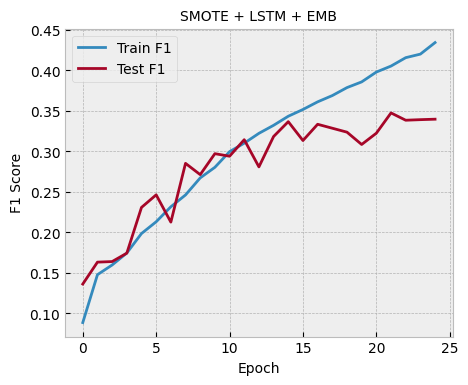

In [ ]:
# Plot
plt.plot(hist.history['f1_score'], label='Train F1')
plt.plot(hist.history['val_f1_score'], label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('SMOTE + LSTM + EMB', fontsize=10)
plt.legend()
plt.show()

In [ ]:
# Guardado como modelo de keras
model.save('smote_lstm_emb.keras')

In [ ]:
# Defino una función para predecir el puntaje a partir de una review
def predecir_puntaje(input_texto, tok, maxlen, model):
    '''
    INPUTS
    input_texto: str
    tok: tokenizador
    maxlen: int para fijar longitud de texto
    model: modelo entrenado previamente

    OUTPUTS
    y_pred: np.array de probabilidades
    puntaje_predicho: int que representa el puntaje
    '''
    # Vector de reviews
    vector_input_texto = np.array([input_texto])

    # Conversión de palabras/tokens a números
    input_final = tok.texts_to_sequences(vector_input_texto)

    # Padding de las sentencias al mismo tamaño.
    input_X = pad_sequences(input_final, padding='pre', maxlen=maxlen)

    # Predicciones
    y_pred = model.predict(input_X)
    puntaje_predicho = np.argmax(y_pred) + 1

    print(f'Para la review: "{input_texto}"')
    print(f'Se predice un puntaje de {puntaje_predicho}/5')

    return y_pred, puntaje_predicho

In [ ]:
# Pruebas varias
input_texto = 'shipping was so slow'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was fast'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'wonderful stuff'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'awesome product'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'this product sucks'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'awful experience'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow but the product is excelent, will buy again'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow but the product is great'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'not happy with the product but return policies worked perfectly'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

# Probemos con faltas de ortografía
input_texto = 'beautifel shirt'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'bbad shirt'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'cualquier cosa'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'not happy'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'happy'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

1/1 [==============================] - 1s 651ms/step
Para la review: "shipping was so slow"
Se predice un puntaje de 1/5
1/1 [==============================] - 0s 19ms/step
Para la review: "shipping was slow"
Se predice un puntaje de 1/5
1/1 [==============================] - 0s 20ms/step
Para la review: "shipping was fast"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 19ms/step
Para la review: "wonderful stuff"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 19ms/step
Para la review: "awesome product"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 19ms/step
Para la review: "this product sucks"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 20ms/step
Para la review: "awful experience"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 25ms/step
Para la review: "shipping was slow but the product is excelent, will buy again"
Se predice un puntaje de 1/5
1/1 [===============

*2.2. SMOTE + Fasttext + LSTM*

Se aplica el método *Synthetic Minority Oversampling Techinque* (SMOTE), se utilizan los embeddings de Fasttext.

In [ ]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
!curl -L -o 'fasttext.pkl' 'https://drive.google.com/u/0/uc?id=1Qi1r-u5lsEsNqRSxLrpNOqQ3B_ufltCa&export=download&confirm=t'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 2746M  100 2746M    0     0  68.2M      0  0:00:40  0:00:40 --:--:-- 75.0M


In [ ]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [ ]:
model_fasttext = FasttextEmbeddings()

In [ ]:
# Crear la Embedding matrix para la cantidad nb_words seleccionadas
# nos vamos a quedar sólo con los vectores de embeddings para las palabras
# que definimos como vocabulario

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index proviene del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))

# word_index está ordenado de mayor a menor frecuencia de palabras
# las primeras que entren en el ciclo for serán las más frecuentes
# Atención! El tokenizador de Keras no tiene soporte para stop words
# las primeras palabras probablemente sean stopwords.
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words que no estén en el índice de la matriz de embedding tendrán
        # como vector de embedding correspondiente todos ceros
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix**2, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [ ]:
# Definimos el modelo

model = Sequential()
model.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                    output_dim=embed_dim, # dimensión de los embeddings utilizados
                    input_length=in_shape, # máxima sentencia de entrada
                    weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=[f1_score, 'accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_2 (LSTM)               (None, 115, 64)           93440     
                                                                 
 dropout_2 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 5)                

In [ ]:
# Punto para cargar el modelo para entrenar por partes
# model = load_model('smote_lstm_fasttext.keras')

In [ ]:
# Entreno el modelo
hist = model.fit(x_sm, y_sm, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
1562/1562 [==============================] - 25s 13ms/step - loss: 0.4793 - f1_score: 0.0347 - accuracy: 0.2928 - val_loss: 0.4295 - val_f1_score: 0.1029 - val_accuracy: 0.4897
Epoch 2/25
1562/1562 [==============================] - 19s 12ms/step - loss: 0.4460 - f1_score: 0.1063 - accuracy: 0.3566 - val_loss: 0.3955 - val_f1_score: 0.1228 - val_accuracy: 0.5330
Epoch 3/25
1562/1562 [==============================] - 19s 12ms/step - loss: 0.4428 - f1_score: 0.1128 - accuracy: 0.3616 - val_loss: 0.3804 - val_f1_score: 0.1315 - val_accuracy: 0.5423
Epoch 4/25
1562/1562 [==============================] - 19s 12ms/step - loss: 0.4358 - f1_score: 0.1200 - accuracy: 0.3738 - val_loss: 0.3779 - val_f1_score: 0.1283 - val_accuracy: 0.5533
Epoch 5/25
1562/1562 [==============================] - 18s 12ms/step - loss: 0.4316 - f1_score: 0.1261 - accuracy: 0.3792 - val_loss: 0.3888 - val_f1_score: 0.1264 - val_accuracy: 0.5270
Epoch 6/25
1562/1562 [==============================] - 18s 

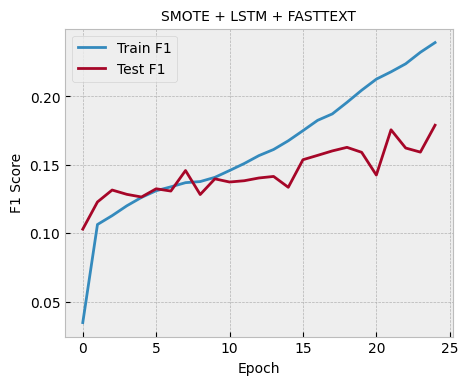

In [ ]:
# Plot
plt.plot(hist.history['f1_score'], label='Train F1')
plt.plot(hist.history['val_f1_score'], label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('SMOTE + LSTM + FASTTEXT', fontsize=10)
plt.legend()
plt.show()

In [ ]:
# Guardado como modelo de keras
model.save('smote_lstm_fasttext.keras')

In [ ]:
# Pruebas varias
input_texto = 'shipping was so slow'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was fast'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'wonderful stuff'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'awesome product'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'this product sucks'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'awful experience'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow but the product is excelent, will buy again'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow but the product is great'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'not happy with the product but return policies worked perfectly'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

# Probemos con faltas de ortografía
input_texto = 'beautifel shirt'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'bbad shirt'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'cualquier cosa'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'not happy'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'happy'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

1/1 [==============================] - 1s 627ms/step
Para la review: "shipping was so slow"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 25ms/step
Para la review: "shipping was slow"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 19ms/step
Para la review: "shipping was fast"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 19ms/step
Para la review: "wonderful stuff"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 19ms/step
Para la review: "awesome product"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 30ms/step
Para la review: "this product sucks"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 31ms/step
Para la review: "awful experience"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 32ms/step
Para la review: "shipping was slow but the product is excelent, will buy again"
Se predice un puntaje de 4/5
1/1 [===============

*2.3. Stratify + Embeddings + LSTM*

Para el desbalance de datos se hace un muestreo estratificado. Por otro lado, se entrenan los embeddings.

In [ ]:
# División de datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [ ]:
# Modelo con LSTM entrenando propios embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=10, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[f1_score, 'accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 115, 10)           20010     
                                                                 
 lstm_4 (LSTM)               (None, 115, 64)           19200     
                                                                 
 dropout_4 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                33024     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 5)                

In [ ]:
# Punto para cargar el modelo para entrenar por partes
# model = load_model('strat_lstm_emb.keras')

In [ ]:
# Entreno el modelo
hist = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
566/566 [==============================] - 28s 43ms/step - loss: 1.0117 - f1_score: 0.1523 - accuracy: 0.5972 - val_loss: 0.8928 - val_f1_score: 0.1652 - val_accuracy: 0.6275
Epoch 2/25
566/566 [==============================] - 8s 15ms/step - loss: 0.8863 - f1_score: 0.1685 - accuracy: 0.6281 - val_loss: 0.8902 - val_f1_score: 0.1650 - val_accuracy: 0.6198
Epoch 3/25
566/566 [==============================] - 10s 18ms/step - loss: 0.8615 - f1_score: 0.1669 - accuracy: 0.6358 - val_loss: 0.8785 - val_f1_score: 0.1654 - val_accuracy: 0.6319
Epoch 4/25
566/566 [==============================] - 8s 14ms/step - loss: 0.8430 - f1_score: 0.1698 - accuracy: 0.6426 - val_loss: 0.8739 - val_f1_score: 0.1639 - val_accuracy: 0.6242
Epoch 5/25
566/566 [==============================] - 9s 16ms/step - loss: 0.8202 - f1_score: 0.1755 - accuracy: 0.6501 - val_loss: 0.8767 - val_f1_score: 0.1689 - val_accuracy: 0.6275
Epoch 6/25
566/566 [==============================] - 9s 15ms/step - loss

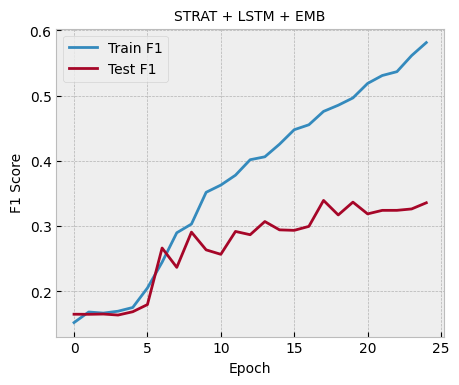

In [ ]:
# Plot
plt.plot(hist.history['f1_score'], label='Train F1')
plt.plot(hist.history['val_f1_score'], label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('STRAT + LSTM + EMB', fontsize=10)
plt.legend()
plt.show()

In [ ]:
# Guardado como modelo de keras
model.save('strat_lstm_emb.keras')

In [ ]:
# Pruebas varias
input_texto = 'shipping was so slow'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was fast'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'wonderful stuff'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'awesome product'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'this product sucks'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'awful experience'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow but the product is excelent, will buy again'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow but the product is great'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'not happy with the product but return policies worked perfectly'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

# Probemos con faltas de ortografía
input_texto = 'beautifel shirt'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'bbad shirt'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'cualquier cosa'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'not happy'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'happy'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

1/1 [==============================] - 1s 619ms/step
Para la review: "shipping was so slow"
Se predice un puntaje de 3/5
1/1 [==============================] - 0s 19ms/step
Para la review: "shipping was slow"
Se predice un puntaje de 3/5
1/1 [==============================] - 0s 29ms/step
Para la review: "shipping was fast"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 40ms/step
Para la review: "wonderful stuff"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 33ms/step
Para la review: "awesome product"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 29ms/step
Para la review: "this product sucks"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 27ms/step
Para la review: "awful experience"
Se predice un puntaje de 3/5
1/1 [==============================] - 0s 34ms/step
Para la review: "shipping was slow but the product is excelent, will buy again"
Se predice un puntaje de 5/5
1/1 [===============

*2.4. Stratify + Fasttext + LSTM*

Para el desbalance de datos se hace un muestreo estratificado. Se utilizan los embeddings de Fasttext.

In [ ]:
# Definimos el modelo

model = Sequential()
model.add(Embedding(input_dim=vocab_size, # definido en el Tokenizador
                    output_dim=embed_dim, # dimensión de los embeddings utilizados
                    input_length=in_shape, # máxima sentencia de entrada
                    weights=[embedding_matrix], # matrix de embeddings
                    trainable=False)) # marcar como layer no entrenable

model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='sigmoid'))

model.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy', f1_score])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 115, 300)          600000    
                                                                 
 lstm_6 (LSTM)               (None, 115, 64)           93440     
                                                                 
 dropout_6 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                

In [ ]:
# Punto para cargar el modelo para entrenar por partes
# model = load_model('strat_lstm_fasttext.keras')

In [ ]:
# Entreno el modelo
hist = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
566/566 [==============================] - 11s 14ms/step - loss: 0.4042 - accuracy: 0.5520 - f1_score: 0.1307 - val_loss: 0.3862 - val_accuracy: 0.5538 - val_f1_score: 0.1344
Epoch 2/25
566/566 [==============================] - 8s 14ms/step - loss: 0.3857 - accuracy: 0.5536 - f1_score: 0.1314 - val_loss: 0.3760 - val_accuracy: 0.5538 - val_f1_score: 0.1408
Epoch 3/25
566/566 [==============================] - 7s 12ms/step - loss: 0.3773 - accuracy: 0.5557 - f1_score: 0.1366 - val_loss: 0.3718 - val_accuracy: 0.5558 - val_f1_score: 0.1460
Epoch 4/25
566/566 [==============================] - 7s 13ms/step - loss: 0.3710 - accuracy: 0.5596 - f1_score: 0.1407 - val_loss: 0.3661 - val_accuracy: 0.5595 - val_f1_score: 0.1353
Epoch 5/25
566/566 [==============================] - 7s 13ms/step - loss: 0.3651 - accuracy: 0.5649 - f1_score: 0.1427 - val_loss: 0.3602 - val_accuracy: 0.5672 - val_f1_score: 0.1433
Epoch 6/25
566/566 [==============================] - 6s 11ms/step - loss:

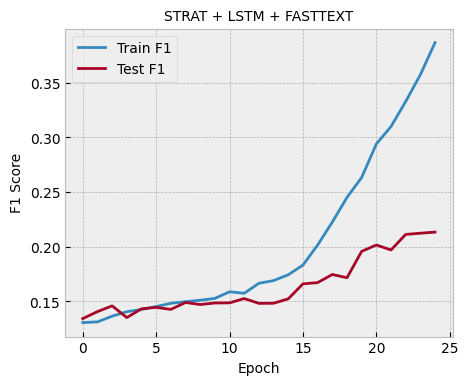

In [ ]:
# Plot
plt.plot(hist.history['f1_score'], label='Train F1')
plt.plot(hist.history['val_f1_score'], label='Test F1')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('STRAT + LSTM + FASTTEXT', fontsize=10)
plt.legend()
plt.show()

In [ ]:
# Guardado como modelo de keras
model.save('strat_lstm_fasttext.keras')

In [ ]:
# Pruebas varias
input_texto = 'shipping was so slow'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was fast'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'wonderful stuff'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'awesome product'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'this product sucks'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'awful experience'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow but the product is excelent, will buy again'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow but the product is great'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'not happy with the product but return policies worked perfectly'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

# Probemos con faltas de ortografía
input_texto = 'beautifel shirt'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'bbad shirt'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'cualquier cosa'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'not happy'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'happy'
y_pred, puntaje_predicho = predecir_puntaje(input_texto, tok, maxlen, model)

1/1 [==============================] - 1s 593ms/step
Para la review: "shipping was so slow"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 24ms/step
Para la review: "shipping was slow"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 21ms/step
Para la review: "shipping was fast"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 18ms/step
Para la review: "wonderful stuff"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 20ms/step
Para la review: "awesome product"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 20ms/step
Para la review: "this product sucks"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 20ms/step
Para la review: "awful experience"
Se predice un puntaje de 5/5
1/1 [==============================] - 0s 20ms/step
Para la review: "shipping was slow but the product is excelent, will buy again"
Se predice un puntaje de 5/5
1/1 [===============

**3. MODELO ALTERNATIVO**

En este apartado planteo la siguiente posibilidad, las estrellas 1 a 5 no son clases sino el redondeo de un puntaje contínuo, el hecho de que figure en valores enteros solo está relacionado con la interfase del usuario.

In [ ]:
# Creación y transformación de la variable y a OHE.
y = df_reviews['Rating'].values
y.shape

(22641,)

In [ ]:
# División de datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y)

In [ ]:
# Se determinan las dimensiones de entrada y salida.
in_shape = X_train.shape[1] # max input sentence len
out_shape = 1
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 115 , out_shape 1


In [ ]:
# Modelo con LSTM entrenando propios embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size+1, output_dim=10, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='relu'))

model.compile(optimizer='adam',
              loss='mean_squared_error')

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 115, 10)           20010     
                                                                 
 lstm_8 (LSTM)               (None, 115, 64)           19200     
                                                                 
 dropout_8 (Dropout)         (None, 115, 64)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                

In [ ]:
hist = model.fit(X_train, y_train, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
566/566 [==============================] - 26s 39ms/step - loss: 1.0975 - val_loss: 0.5891
Epoch 2/25
566/566 [==============================] - 9s 16ms/step - loss: 0.6111 - val_loss: 0.5668
Epoch 3/25
566/566 [==============================] - 7s 13ms/step - loss: 0.5633 - val_loss: 0.6137
Epoch 4/25
566/566 [==============================] - 8s 13ms/step - loss: 0.5354 - val_loss: 0.5593
Epoch 5/25
566/566 [==============================] - 7s 12ms/step - loss: 0.5084 - val_loss: 0.5675
Epoch 6/25
566/566 [==============================] - 8s 14ms/step - loss: 0.4860 - val_loss: 0.5887
Epoch 7/25
566/566 [==============================] - 7s 12ms/step - loss: 0.4596 - val_loss: 0.5975
Epoch 8/25
566/566 [==============================] - 7s 13ms/step - loss: 0.4340 - val_loss: 0.6032
Epoch 9/25
566/566 [==============================] - 8s 14ms/step - loss: 0.4123 - val_loss: 0.6108
Epoch 10/25
566/566 [==============================] - 6s 11ms/step - loss: 0.3935 - val_l

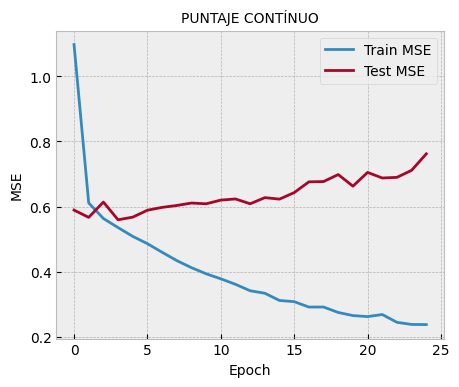

In [ ]:
# Plot
plt.plot(hist.history['loss'], label='Train MSE')
plt.plot(hist.history['val_loss'], label='Test MSE')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('PUNTAJE CONTÍNUO', fontsize=10)
plt.legend()
plt.show()

In [ ]:
# Guardado como modelo de keras
model.save('strat_lstm_emb_continuo.keras')

In [ ]:
# Defino una función para predecir el puntaje a partir de una review
def predecir_puntaje(input_texto, tok, maxlen, model):
    '''
    INPUTS
    input_texto: str
    tok: tokenizador
    maxlen: int para fijar longitud de texto
    model: modelo entrenado previamente

    OUTPUTS
    y_pred: np.array de probabilidades
    puntaje_predicho: int que representa el puntaje
    '''
    # Vector de reviews
    vector_input_texto = np.array([input_texto])

    # Conversión de palabras/tokens a números
    input_final = tok.texts_to_sequences(vector_input_texto)

    # Padding de las sentencias al mismo tamaño.
    input_X = pad_sequences(input_final, padding='pre', maxlen=maxlen)

    # Predicciones
    y_pred = model.predict(input_X)
    y_print = round(y_pred[0][0], 1)

    print(f'Para la review: "{input_texto}"')
    print(f'Se predice un puntaje de {y_print}/5')

    return y_pred

In [ ]:
# Pruebas varias
input_texto = 'shipping was so slow'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was fast'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'wonderful stuff'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'awesome product'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'this product sucks'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'awful experience'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow but the product is excelent, will buy again'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'shipping was slow but the product is great'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'not happy with the product but return policies worked perfectly'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

# Probemos con faltas de ortografía
input_texto = 'beautifel shirt'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'bbad shirt'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'cualquier cosa'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'not happy'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

input_texto = 'happy'
y_pred = predecir_puntaje(input_texto, tok, maxlen, model)

1/1 [==============================] - 1s 1s/step
Para la review: "shipping was so slow"
Se predice un puntaje de 0.30000001192092896/5
1/1 [==============================] - 0s 22ms/step
Para la review: "shipping was slow"
Se predice un puntaje de 0.4000000059604645/5
1/1 [==============================] - 0s 20ms/step
Para la review: "shipping was fast"
Se predice un puntaje de 0.0/5
1/1 [==============================] - 0s 26ms/step
Para la review: "wonderful stuff"
Se predice un puntaje de 4.300000190734863/5
1/1 [==============================] - 0s 20ms/step
Para la review: "awesome product"
Se predice un puntaje de 4.099999904632568/5
1/1 [==============================] - 0s 21ms/step
Para la review: "this product sucks"
Se predice un puntaje de 1.100000023841858/5
1/1 [==============================] - 0s 21ms/step
Para la review: "awful experience"
Se predice un puntaje de 0.10000000149011612/5
1/1 [==============================] - 0s 20ms/step
Para la review: "shipping was

**4. CONCLUSIONES**

Los modelos no presentan buenas métricas y tienden rápidamente al overfitting. Se hicieron numerosas pruebas con más y menos capas y con capas bidireccionales, y los resultados no mejoraron significativamente. Dependiendo del mínimo local en que caiga el entrenamiento parecen tener más o menos sentido las respuestas en las pruebas manuales. El accuracy en general estuvo alrededor del 60%, valor algo mayor al porcentaje de valores de 5 estrellas del dataset original. Se observaron métricas mejores cuando se entrenaron los embeddings que cuando se importaron. Para mejorar los resultados parece necesario contar con más datos de entrenamiento.